### Document Parsing with Qwen3-VL

Welcome to this notebook, which showcases the powerful document parsing capabilities of our model. It can process any image and output its contents in various formats such as HTML, JSON, Markdown, and LaTeX. Notably, we introduce two unique Qwenvl formats:

- Qwenvl HTML format, which adds positional information for each component to enable precise document reconstruction and manipulation.
- Qwenvl Markdown format, which converts the overall image content into Markdown. In this format, all tables are represented in LaTeX with their corresponding coordinates indicated before each table, and images are replaced with coordinate-based placeholders for accurate positioning.

This allows for highly detailed and flexible document parsing and reconstruction.

#### \[Setup\]

Load visualization utils.

In [3]:
!pip install git+https://github.com/huggingface/transformers
!pip install qwen-vl-utils
!pip install qwen_agent
!pip install openai

Looking in indexes: https://mirrors.aliyun.com/pypi/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-e8i5oarn
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-e8i5oarn
  fatal: unable to access 'https://github.com/huggingface/transformers/': SSL: certificate subject name (github.aliyun-inc.com) does not match target host name 'github.com'
  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-e8i5oarn did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-e8i5oarn did not run successfully.
│ exit code: 128
╰─> See above for o

In [23]:
# Get Noto font
!apt-get install fonts-noto-cjk 

import requests
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO
from bs4 import BeautifulSoup, Tag
import re

# Function to draw bounding boxes and text on images based on HTML content
def draw_bbox_html(image_path, full_predict):
    """
    可视化 Qwenvl HTML 的 data-bbox 框并展示文本，坐标为相对 0-1000。
    过滤规则：跳过 <ol>，仅绘制 <li> 子项和其它元素。
    """
    # 读取图片
    if image_path.startswith("http"):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_path).convert("RGB")
    width = image.width
    height = image.height

    soup = BeautifulSoup(full_predict, 'html.parser')
    elements_with_bbox = soup.find_all(attrs={'data-bbox': True})

    # 保留原过滤逻辑
    filtered_elements = []
    for el in elements_with_bbox:
        if el.name == 'ol':
            continue  # 跳过 <ol>
        elif el.name == 'li' and el.parent.name == 'ol':
            filtered_elements.append(el)  # 仅保留 <ol> 下的 <li>
        else:
            filtered_elements.append(el)

    # 字体兼容
    try:
        font = ImageFont.truetype("NotoSansCJK-Regular.ttc", 10)
    except Exception:
        font = ImageFont.load_default()
    draw = ImageDraw.Draw(image)
    
    # 绘制框与文本
    for element in filtered_elements:
        bbox_str = element['data-bbox']
        text = element.get_text(strip=True)
        try:
            x1, y1, x2, y2 = map(int, bbox_str.split())
        except Exception:
            continue

        bx1 = int(x1 / 1000 * width)
        by1 = int(y1 / 1000 * height)
        bx2 = int(x2 / 1000 * width)
        by2 = int(y2 / 1000 * height)
        
        if bx1 > bx2:
            bx1, bx2 = bx2, bx1
        if by1 > by2:
            by1, by2 = by2, by1
            
        draw.rectangle([bx1, by1, bx2, by2], outline='red', width=2)
        draw.text((bx1, by2), text, fill='black', font=font)

    image.show()

    
# Function to draw bounding boxes on images based on Markdown content
def draw_bbox_markdown(image_path, md_content):
    """
    只可视化Markdown中的 <!-- Image/Table (x1, y1, x2, y2) --> 坐标框，坐标为相对0-1000
    Table 用绿色框，Image 用蓝色框。
    """
    if image_path.startswith("http"):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_path).convert("RGB")
    width = image.width
    height = image.height

    pattern = r"<!-- (Image|Table) \(\s*(\d+)\s*,\s*(\d+)\s*,\s*(\d+)\s*,\s*(\d+)\s*\) -->"
    matches = re.findall(pattern, md_content)
    draw = ImageDraw.Draw(image)
    for item in matches:
        typ, x1, y1, x2, y2 = item
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        bx1 = int(x1 / 1000 * width)
        by1 = int(y1 / 1000 * height)
        bx2 = int(x2 / 1000 * width)
        by2 = int(y2 / 1000 * height)
        if bx1 > bx2:
            bx1, bx2 = bx2, bx1
        if by1 > by2:
            by1, by2 = by2, by1
        color = 'blue' if typ == "Image" else 'red'
        draw.rectangle([bx1, by1, bx2, by2], outline=color, width=6)

    image.show()


# Function to clean and format HTML content
def clean_and_format_html(full_predict):
    soup = BeautifulSoup(full_predict, 'html.parser')
    
    # Regular expression pattern to match 'color' styles in style attributes
    color_pattern = re.compile(r'\bcolor:[^;]+;?')

    # Find all tags with style attributes and remove 'color' styles
    for tag in soup.find_all(style=True):
        original_style = tag.get('style', '')
        new_style = color_pattern.sub('', original_style)
        if not new_style.strip():
            del tag['style']
        else:
            new_style = new_style.rstrip(';')
            tag['style'] = new_style
            
    # Remove 'data-bbox' and 'data-polygon' attributes from all tags
    for attr in ["data-bbox", "data-polygon"]:
        for tag in soup.find_all(attrs={attr: True}):
            del tag[attr]

    classes_to_update = ['formula.machine_printed', 'formula.handwritten']
    # Update specific class names in div tags
    for tag in soup.find_all(class_=True):
        if isinstance(tag, Tag) and 'class' in tag.attrs:
            new_classes = [cls if cls not in classes_to_update else 'formula' for cls in tag.get('class', [])]
            tag['class'] = list(dict.fromkeys(new_classes))  # Deduplicate and update class names

    # Clear contents of divs with specific class names and rename their classes
    for div in soup.find_all('div', class_='image caption'):
        div.clear()
        div['class'] = ['image']

    classes_to_clean = ['music sheet', 'chemical formula', 'chart']
    # Clear contents and remove 'format' attributes of tags with specific class names
    for class_name in classes_to_clean:
        for tag in soup.find_all(class_=class_name):
            if isinstance(tag, Tag):
                tag.clear()
                if 'format' in tag.attrs:
                    del tag['format']

    # Manually build the output string
    output = []
    for child in soup.body.children:
        if isinstance(child, Tag):
            output.append(str(child))
            output.append('\n')  # Add newline after each top-level element
        elif isinstance(child, str) and not child.strip():
            continue  # Ignore whitespace text nodes
    complete_html = f"""```html\n<html><body>\n{" ".join(output)}</body></html>\n```"""
    return complete_html

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-noto-cjk is already the newest version (1:20220127+repack1-1).
0 upgraded, 0 newly installed, 0 to remove and 159 not upgraded.


inference function with API

In [15]:
from openai import OpenAI
import os
import base64
#  base 64 编码格式
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


# @title inference function with API
def inference_with_api(image_path, prompt, model_id="pre-qwen3vl-235A22-instruct-0918-model", min_pixels=512*32*32, max_pixels=2048*32*32):
    base64_image = encode_image(image_path)
    client = OpenAI(
        #If the environment variable is not configured, please replace the following line with the Dashscope API Key: api_key="sk-xxx".
        api_key=os.getenv('DASHSCOPE_API_KEY'),
        base_url="https://poc-dashscope.aliyuncs.com/compatible-mode/v1",
    )


    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "min_pixels": min_pixels,
                    "max_pixels": max_pixels,
                    # Pass in BASE64 image data. Note that the image format (i.e., image/{format}) must match the Content Type in the list of supported images. "f" is the method for string formatting.
                    # PNG image:  f"data:image/png;base64,{base64_image}"
                    # JPEG image: f"data:image/jpeg;base64,{base64_image}"
                    # WEBP image: f"data:image/webp;base64,{base64_image}"
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                },
                {"type": "text", "text": prompt},
            ],
        }
    ]
    completion = client.chat.completions.create(
        model = model_id,
        messages = messages,
       
    )
    return completion.choices[0].message.content

#### 1. Document Parsing in QwenVL HTML Format

Here shows how to generate and process HTML content using Qwen2.5-VL. The generated HTML follows the QwenVL Document Parser format with bounding boxes.

1696 1216
<html><body><div class="image" data-bbox="104 29 455 75"></div>
<div class="image" data-bbox="15 49 46 142"></div>
<div class="image" data-bbox="17 270 45 407"></div>
<div class="image" data-bbox="20 581 47 698"></div>
<div class="text" data-bbox="91 101 346 127">宇通客车 (600066)</div>
<div class="text" data-bbox="91 140 489 167">7月销量转正，T7前景看好</div>
<div class="text" data-bbox="107 202 259 223">推荐（维持）</div>
<div class="text" data-bbox="108 241 245 257">现价：22.06 元</div>
<div class="text" data-bbox="108 275 169 287">主要数据</div>
<div class="table" data-bbox="108 298 386 446"><table><tr><td>行业</td><td>汽车和汽车零部件</td></tr><tr><td>公司网址</td><td>www.yutong.com</td></tr><tr><td>大股东/持股</td><td>宇通集团/37.19%</td></tr><tr><td>总股本(百万股)</td><td>2,214</td></tr><tr><td>流通A股(百万股)</td><td>1,903</td></tr><tr><td>流通B/H股(百万股)</td><td>0</td></tr><tr><td>总市值(亿元)</td><td>488.39</td></tr><tr><td>流通A股市值(亿元)</td><td>419.91</td></tr><tr><td>每股净资产(元)</td><td>6.28</td></tr><tr><td>资产负债率(%)</td><td>52.30</td></tr>

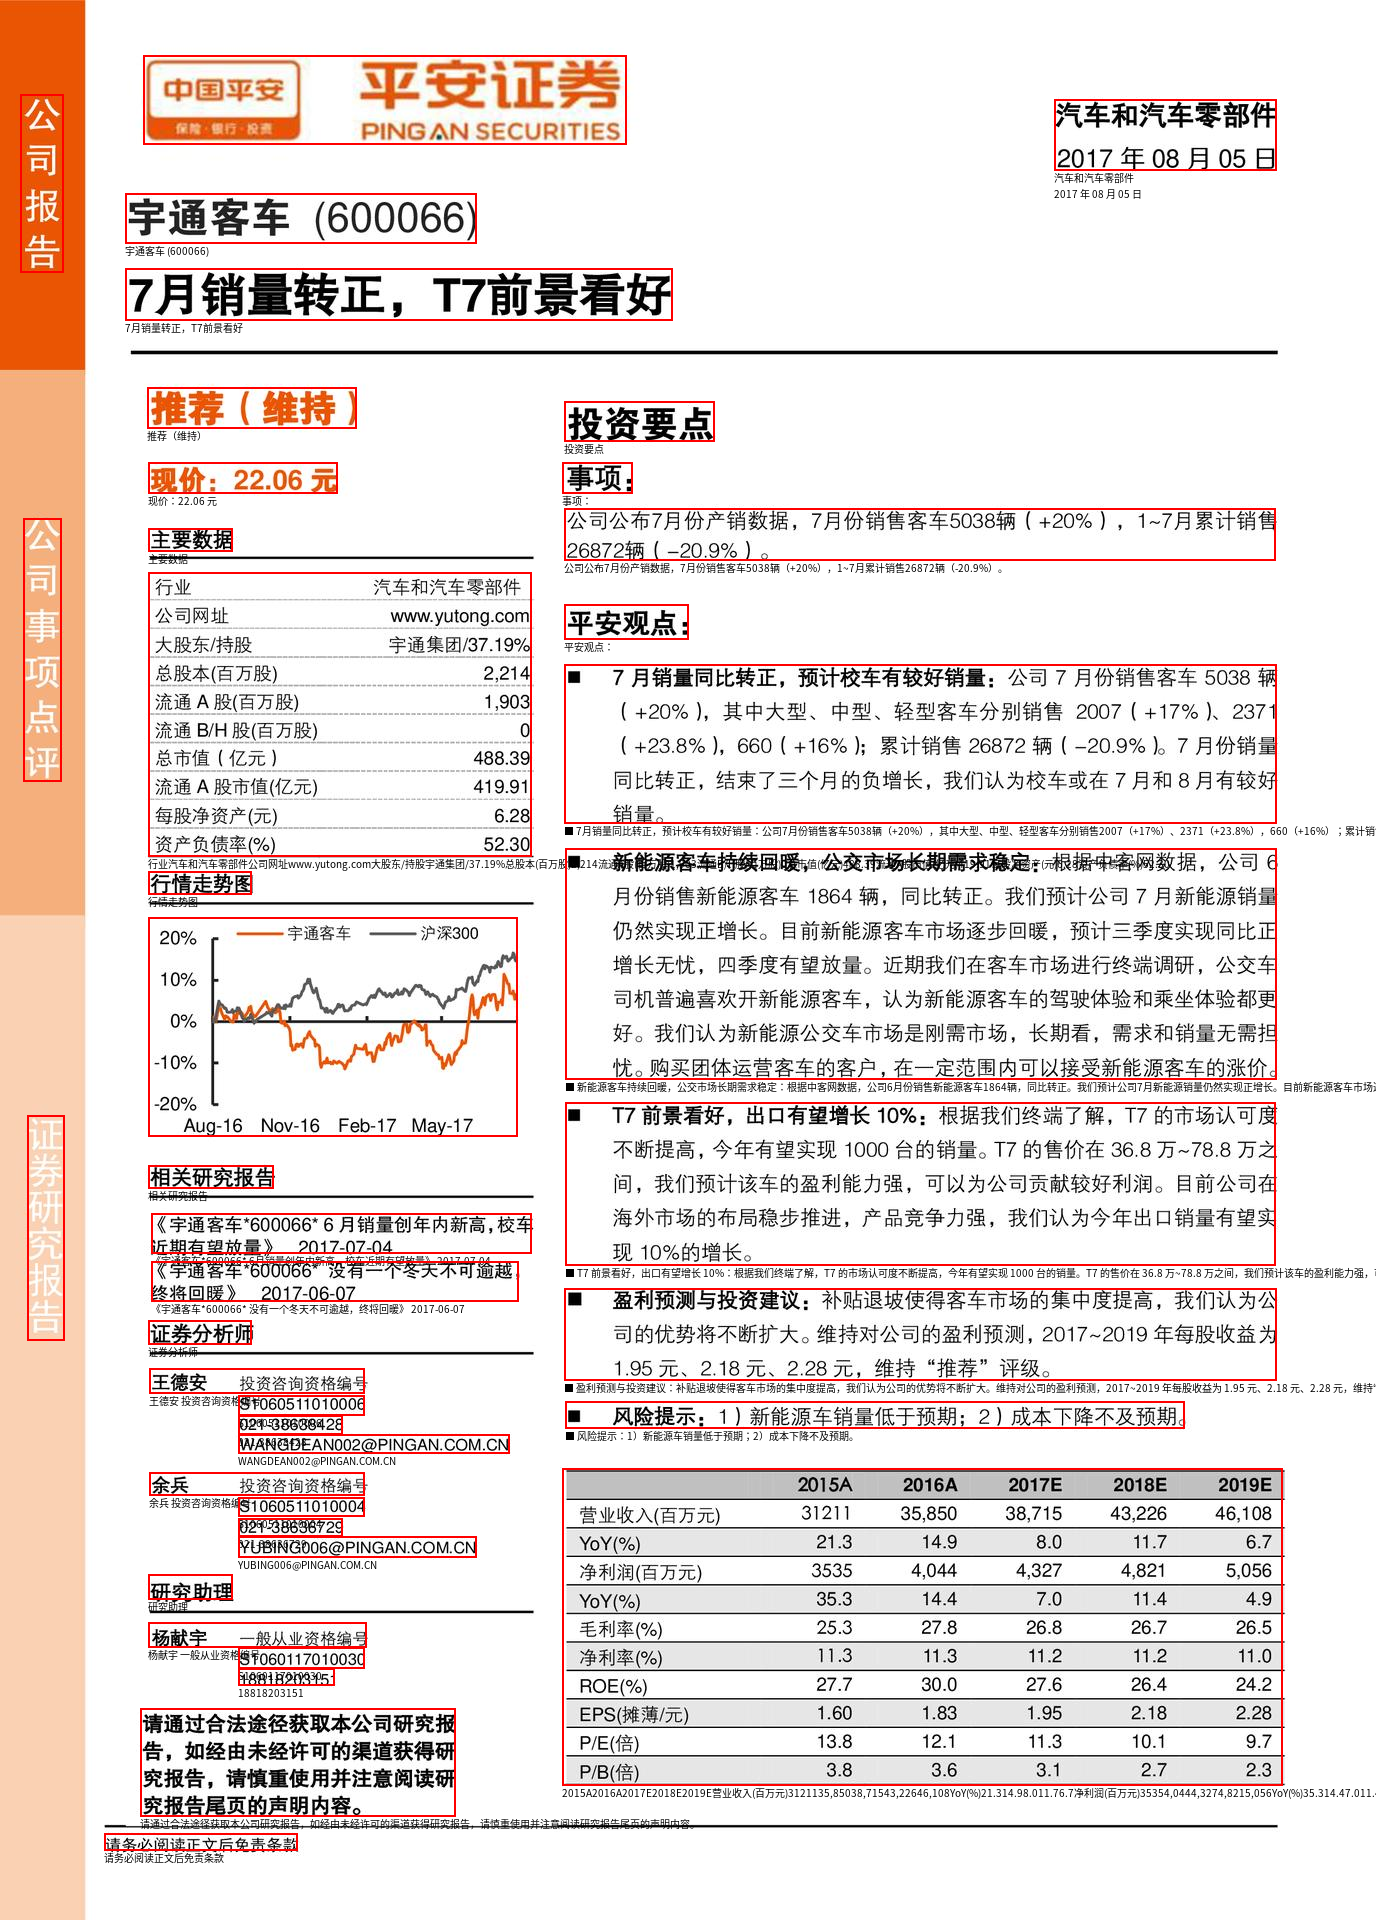

```html
<html><body>
<div class="image"></div> 
 <div class="image"></div> 
 <div class="image"></div> 
 <div class="image"></div> 
 <div class="text">宇通客车 (600066)</div> 
 <div class="text">7月销量转正，T7前景看好</div> 
 <div class="text">推荐（维持）</div> 
 <div class="text">现价：22.06 元</div> 
 <div class="text">主要数据</div> 
 <div class="table"><table><tr><td>行业</td><td>汽车和汽车零部件</td></tr><tr><td>公司网址</td><td>www.yutong.com</td></tr><tr><td>大股东/持股</td><td>宇通集团/37.19%</td></tr><tr><td>总股本(百万股)</td><td>2,214</td></tr><tr><td>流通A股(百万股)</td><td>1,903</td></tr><tr><td>流通B/H股(百万股)</td><td>0</td></tr><tr><td>总市值(亿元)</td><td>488.39</td></tr><tr><td>流通A股市值(亿元)</td><td>419.91</td></tr><tr><td>每股净资产(元)</td><td>6.28</td></tr><tr><td>资产负债率(%)</td><td>52.30</td></tr></table></div> 
 <div class="text">行情走势图</div> 
 <div class="image"></div> 
 <div class="text">相关研究报告</div> 
 <div class="text">《宇通客车*600066* 6月销量创年内新高，校车近期有望放量》 2017-07-04</div> 
 <div class="text">《宇通客车*600066* 没有一个冬天不可逾越，终将回暖》 2017-06-07</div> 
 <di

In [20]:
import requests
from io import BytesIO
import os

img_url = "https://ofasys-multimodal-wlcb-3-toshanghai.oss-cn-shanghai.aliyuncs.com/Qwen3VL/demo/omni_parsing/179729.jpg"
response = requests.get(img_url)
img_name = os.path.basename(img_url)
image = Image.open(BytesIO(response.content))
image.save(img_name)

prompt = "qwenvl html"

# Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here'
min_pixels = 512*32*32
max_pixels = 2048*32*32
width, height = image.size
input_height, input_width = smart_resize(height, width, min_pixels=min_pixels, max_pixels=max_pixels, factor=32)
output = inference_with_api(img_name, prompt, min_pixels=min_pixels, max_pixels=max_pixels)


# Visualization
print(input_height, input_width)
print(output)
draw_bbox_html(img_url, output)

ordinary_html = clean_and_format_html(output)
print(ordinary_html)

#### 2. Document Parsing in QwenVL Markdown Format

Here shows how to generate and process Markdown content using Qwen3-VL. The generated Markdown follows the QwenVL Markdown format, including positional information. In this format, all detected tables are represented as LaTeX with their corresponding coordinates indicated before each table, and images are replaced with coordinate-based placeholders for accurate positioning.

1760 2560
```markdown
荣德基
点拨
训练
# 第二学期期末测试卷
九年级化学·下(KX版) 时间:90分钟 满分:100分

可能用到的相对原子质量:H:1 C:12 O:16 Na:23 Cl:35.5 Ca:40

## 一、选择题(本题包括15小题,每小题3分,共45分。每小题的4个选项中只有1个符合题意)

1. 把少量下列物质分别放入足量水中,充分搅拌,可以得到无色溶液的是()
A. 氯化铁 B. 氢氧化镁 C. 小苏打 D. 汽油

2. 下列有关物质的俗称、化学式、类别及常见用途的说法中,完全正确的一组是()
<!-- Table (76, 311, 339, 406) -->
\begin{tabular}{|c|c|c|c|c|}
\hline
选项 & 俗称 & 化学式 & 类别 & 常见用途 \\
\hline
A & 消石灰 & Ca(OH)₂ & 碱 & 用作建筑材料 \\
\hline
B & 石灰石 & CaO & 氧化物 & 用作食品干燥剂 \\
\hline
C & 小苏打 & NaHCO₃ & 酸 & 用于焙制糕点 \\
\hline
D & 纯碱 & Na₂CO₃ & 碱 & 用于玻璃、洗涤剂的生产 \\
\hline
\end{tabular}

3. 化学实验室常需要配制溶液,下列说法正确的是()
A. 配制溶液时,只能用水作溶剂
B. 配制硝酸铵溶液的过程中,溶液的温度会下降
C. 用浓硫酸配制稀硫酸时,应将水缓缓注入浓硫酸中
D. 将10g氯化钠溶于100g水中,得到质量分数为10%的氯化钠溶液

4. 浓盐酸和浓硫酸对比,下列叙述正确的是()
A. 两者均具有挥发性 B. 两者均具有刺激性气味
C. 两者均具有腐蚀性 D. 两者均是黏稠状液体

5. 关注健康,预防疾病。下列叙述错误的是()
A. 人体胃液正常的pH范围在0.9~1.5
B. 人体缺乏维生素A会引起坏血病
C. 香烟的烟气中含多种对人体有害的物质
D. 人体缺碘会引起甲状腺肿大,碘过量也会引起甲状腺肿大

6. 下列实验现象描述正确的是()
A. 氢氧化钠固体放置于空气中:表面潮湿并逐渐溶解
B. 高锰酸钾放入汽油中:很快溶解形成紫色溶液
C. 将二氧化碳通入紫色石蕊溶液中:紫色石蕊溶液变蓝色
D. 涤纶和羊毛燃烧:都可闻到一股烧

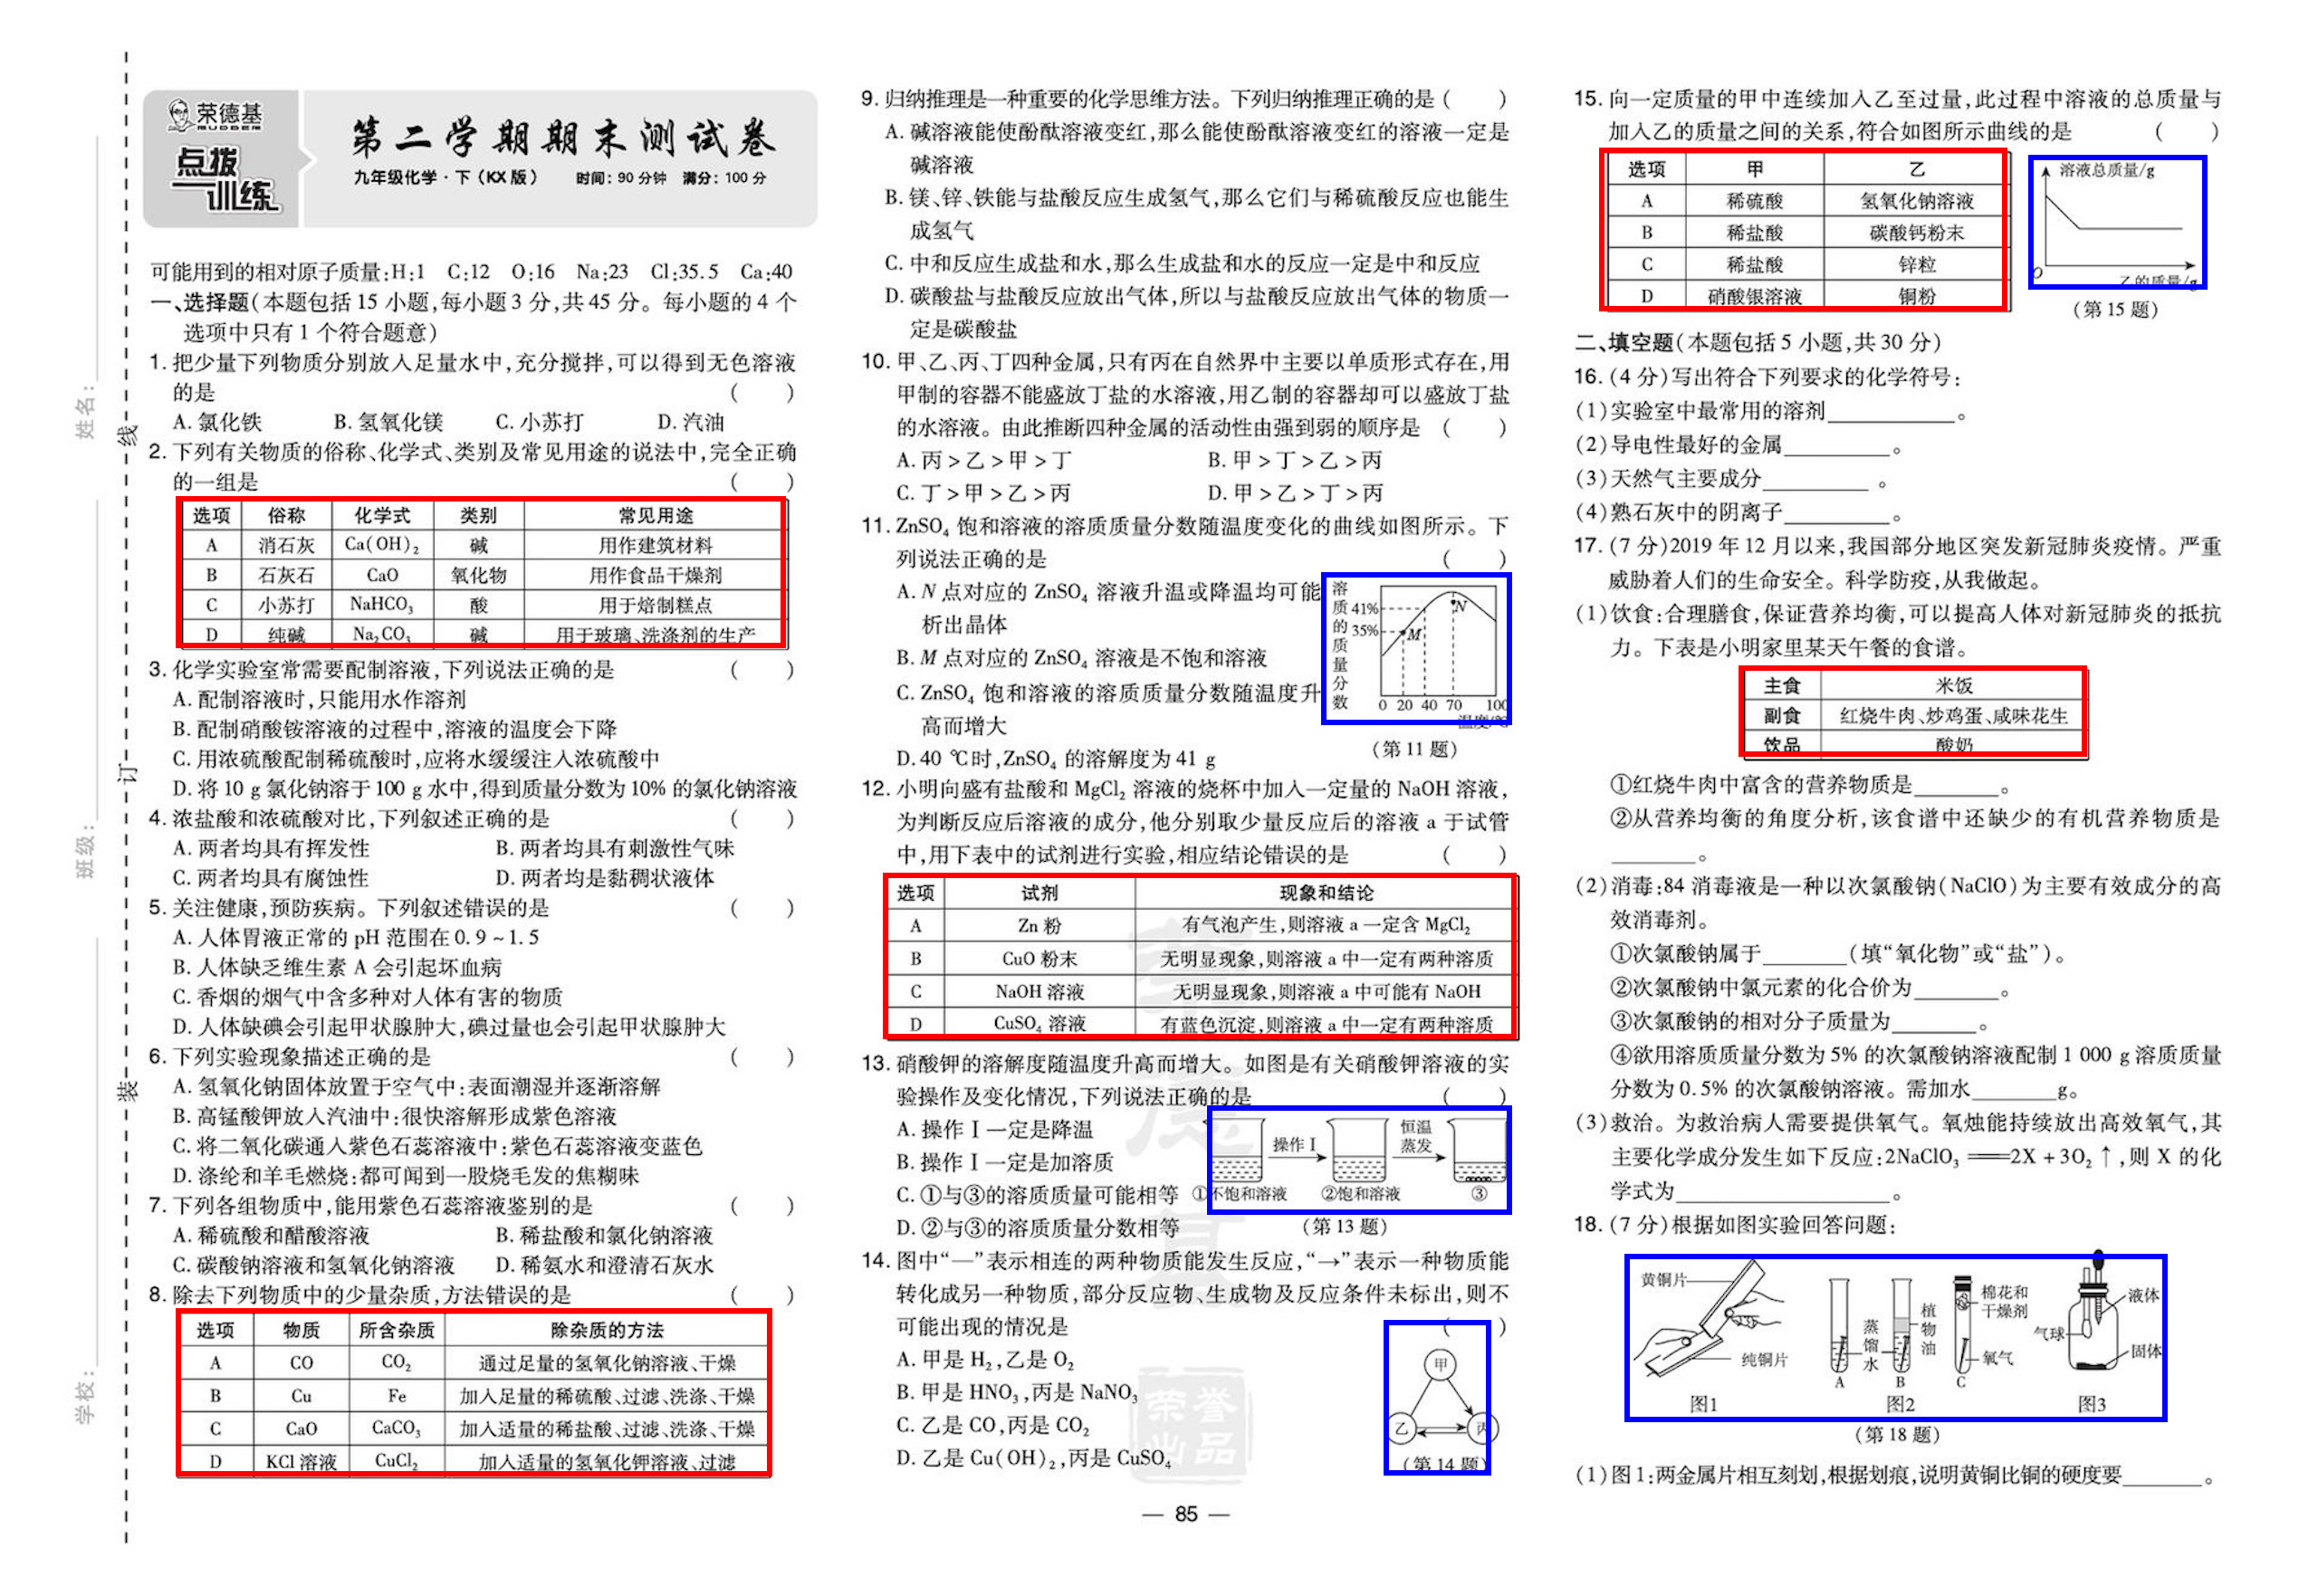

In [35]:
import requests
from io import BytesIO
import os

img_url = "https://ofasys-multimodal-wlcb-3-toshanghai.oss-cn-shanghai.aliyuncs.com/Qwen3VL/demo/omni_parsing/120922.jpg"
response = requests.get(img_url)
img_name = os.path.basename(img_url)
image = Image.open(BytesIO(response.content))
image.save(img_name)

prompt = "qwenvl markdown"

# Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here'
min_pixels = 512*32*32
max_pixels = 4608*32*32
width, height = image.size
input_height, input_width = smart_resize(height, width, min_pixels=min_pixels, max_pixels=max_pixels, factor=32)
output = inference_with_api(img_name, prompt, min_pixels=min_pixels, max_pixels=max_pixels)


# Visualization
print(input_height, input_width)
print(output)
draw_bbox_markdown(img_url, output)
